In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
df = pd.read_csv("../enhanced_anesthesia_dataset_v4.csv")

In [3]:
features = [
    'Age', 'Gender', 'Height_cm', 'Weight_kg', 'BMI', 'IBW', 'ABW', 'Diet',
    'OrganFunction', 'KidneyFunction', 'CardiovascularHistory', 'Diabetes',
    'CurrentMedications', 'ProcedureType', 'ASA_Class', 'ALDH2_Genotype',
    'CYP2D6_Type', 'CYP3A4_Type', 'CYP2C9_Type', 'CYP2B6_Type',
    'UGT1A1_Variant', 'RYR1_Variant', 'SCN9A_Variant', 'F5_Variant',
    'GABRA2_Variant', 'OPRM1_Variant'
]


In [4]:
target = 'General_AnesthesiaType'

In [5]:
# Step 1: Group by classes
classes = df[target].unique()
upsampled_frames = []

for cls in classes:
    class_df = df[df[target] == cls]
    
    if len(class_df) == 0:
        print(f"Warning: Class '{cls}' has 0 samples. Skipping.")
        continue  # Skip if no data for this class

    if len(class_df) < 500:
        # Upsample
        upsampled = resample(
            class_df,
            replace=True,
            n_samples=500,
            random_state=42
        )
        upsampled_frames.append(upsampled)
    else:
        # Keep original
        upsampled_frames.append(class_df)

# Step 2: Combine and shuffle
balanced_df = pd.concat(upsampled_frames).sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df[features], balanced_df[target], test_size=0.2, random_state=42, stratify=balanced_df[target]
)

In [7]:
cat_features = [i for i, col in enumerate(X_train.columns) if balanced_df[col].dtype == 'object']

In [8]:
model = CatBoostClassifier(
    verbose=100,
    random_state=42,
    loss_function='MultiClass'
)
model.fit(X_train, y_train, cat_features=cat_features)

Learning rate set to 0.09445
0:	learn: 1.3530604	total: 260ms	remaining: 4m 19s
100:	learn: 0.0904198	total: 13.1s	remaining: 1m 56s
200:	learn: 0.0561273	total: 26.1s	remaining: 1m 43s
300:	learn: 0.0431578	total: 37.8s	remaining: 1m 27s
400:	learn: 0.0345346	total: 49.5s	remaining: 1m 13s
500:	learn: 0.0284051	total: 1m 1s	remaining: 1m 1s
600:	learn: 0.0250535	total: 1m 13s	remaining: 48.9s
700:	learn: 0.0219721	total: 1m 25s	remaining: 36.6s
800:	learn: 0.0197479	total: 1m 37s	remaining: 24.3s
900:	learn: 0.0176041	total: 1m 50s	remaining: 12.1s
999:	learn: 0.0156411	total: 2m 2s	remaining: 0us


In [9]:
y_pred = model.predict(X_test)

In [10]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


📊 Classification Report:
              precision    recall  f1-score   support

  Desflurane       1.00      1.00      1.00      2649
  Isoflurane       1.00      1.00      1.00       666
    Ketamine       0.99      0.99      0.99       100
    Propofol       0.99      0.99      0.99      1425
 Sevoflurane       1.00      1.00      1.00      3203

    accuracy                           1.00      8043
   macro avg       1.00      1.00      1.00      8043
weighted avg       1.00      1.00      1.00      8043



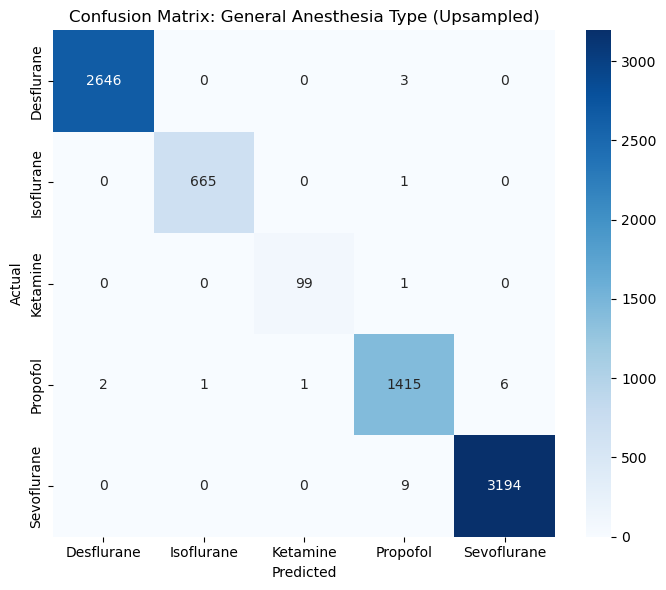

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix: General Anesthesia Type (Upsampled)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

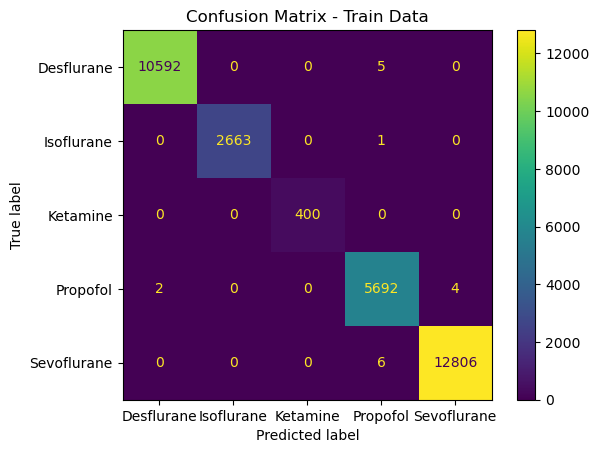

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predict on Train set
y_train_pred = model.predict(X_train)

# Predict on Test set
y_test_pred = model.predict(X_test)

# 1. Confusion Matrix on Train data
train_cm = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=model.classes_)
disp_train.plot()
plt.title("Confusion Matrix - Train Data")
plt.show()


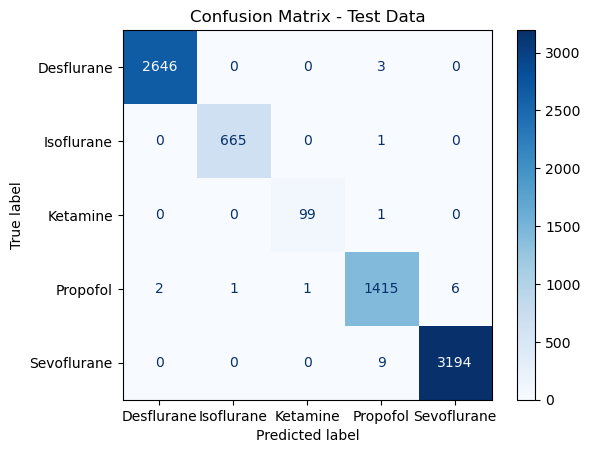

In [13]:
# 2. Confusion Matrix on Test data (first view)
test_cm = confusion_matrix(y_test, y_test_pred)
disp_test1 = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
disp_test1.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Data")
plt.show()

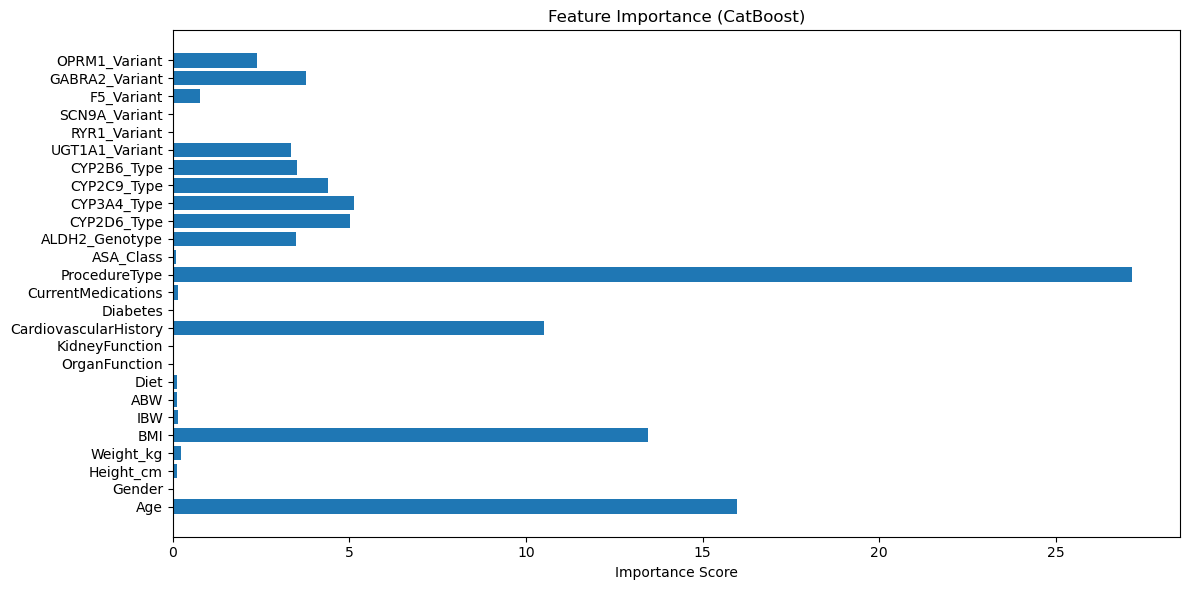

In [14]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

In [15]:
os.makedirs("saved_model", exist_ok=True)
model.save_model("saved_model/anesthesia_type_model_catBoost_upsampled.cbm")
joblib.dump({
    "features": features,
    "cat_features": cat_features,
    "target": target
}, "saved_model/model_metadata.pkl")

print("\nModel saved to 'saved_model/anesthesia_type_model_upsampled.cbm'")


Model saved to 'saved_model/anesthesia_type_model_upsampled.cbm'
